# Predicting MLB Strikeout Rates from Velocity and Movement

Using data from 2012-2016, we first determine a classification system for different pitches using a clustering algorithm.  Motivation for this work was provided by http://www.sloansportsconference.com/wp-content/uploads/2019/02/Predicting-Major-League-Baseball-Strikeout-Rates-Update.pdf.

These features are then used to construct a model to predict strikeout rates using several regression models.

In [1]:
from pybaseball import statcast, pitching_stats, pitching_stats_range
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### get the data

The raw data is scraped from statcast and/or pitch fx using the pybaseball module.  We remove "short relievers" by keeping only pitchers that have thrown at least 1000 pitches in a season AND that average 10 batters faced per appearance.

The data columns used from the pitcher data are:

- game_pk: the unique game ID
- inning: inning of the pitch
- game_year: the year of the data
- player_name: the pitcher's name (this is used to join to a separate data pull that is required to extract strikeouts per 9 innings)
- batter: used to keep track of batters faced
- release_speed: speed of the ball at time of release (feature used for pitch categorization in the clustering algorithm)
- pfx_x, pfx_z: movement in the horizontal and vertical directions (features used for pitch categorization in the clustering algorithm)

In [2]:
NL_TEAMS = ['Braves', 'Brewers', 'Cardinals', 'Cubs', 'Diamondbacks', 'Dodgers', 'Giants',
            'Marlins', 'Mets', 'Nationals', 'Padres', 'Phillies', 'Pirates', 'Reds', 'Rockies']

AL_TEAMS = ['Angels', 'Astros', 'Athletics', 'Blue Jays', 'Indians', 'Mariners', 'Orioles', 
            'Rangers', 'Rays', 'Red Sox', 'Royals', 'Tigers', 'Twins', 'White Sox', 'Yankees']

def team_to_league(x):
    if x in NL_TEAMS:
        return 0
    elif x in AL_TEAMS:
        return 1
    else:
        return 2

def avg_batters_faced(df, pitcher_id):
    
    # subset the given pitcher's games
    temp_df = df[df['pitcher']==pitcher_id]
    
    # count number of batters faced in each game
    temp_df = temp_df.drop_duplicates(subset=['game_pk', 'inning', 'batter'])
    total_batters_faced = len(temp_df)

    # count the number of appearances
    number_of_games = len(temp_df['game_pk'].unique())
    
    # return the average number of batters faced per game
    return round(total_batters_faced / number_of_games, 1)


def get_speed_location_data(start, end):

    # get the raw pitch data from statcast
    pitch_data = statcast(start_dt=start, end_dt=end)
    
    # make sure index columns are int
    pitch_data['game_pk'] = pitch_data['game_pk'].astype(int)
    pitch_data['inning'] = pitch_data['inning'].astype(int)
    pitch_data['game_year'] = pitch_data['game_year'].astype(int)
    pitch_data['pitcher'] = pitch_data['pitcher'].astype(int)
    pitch_data['batter'] = pitch_data['batter'].astype(int)
    
    # get the data for K rate and to compute the pitcher's strike percentage
    strike_data = pitching_stats(start[:4])
    strike_data = strike_data[['Season', 'Name', 'Team', 'SO', 'TBF', 'Pitches', 'Strikes']]
    strike_data.columns = ['game_year', 'player_name', 'team', 'SO', 'TBF', 'Pitches', 'Strikes']
    strike_data['k_rate'] = strike_data['SO'] / strike_data['TBF']
    strike_data['strike_pct'] = strike_data['Strikes'] / strike_data['Pitches']
    strike_data['league'] = strike_data['team'].apply(team_to_league)
    strike_data.drop(['team', 'SO', 'TBF', 'Pitches', 'Strikes'], axis=1, inplace=True)
    strike_data['game_year'] = strike_data['game_year'].astype(int)
    
    # merge the two dataframes together
    pitch_data = pd.merge(pitch_data, strike_data, how='inner', on=['game_year', 'player_name'])
        
    # select the columns that we need
    cols_to_keep = ['game_pk', 'inning', 'game_year', 'player_name', 'league', 'pitcher', 'batter', 'release_speed', 'pfx_x', 'pfx_z', 'hc_x', 'hc_y', 'strike_pct', 'k_rate']
    pitch_data = pitch_data[cols_to_keep]
    
    # drop any rows that have no game_pk
    pitch_data = pitch_data[~pd.isnull(pitch_data['game_pk'])]
    
    # make an index for observations 
    pitch_data['obs_index'] = pitch_data['game_year'].astype(str) + "_" + pitch_data['pitcher'].astype(str)
    
    # get a count of pitchers and number of pitches they threw
    pitcher_count = dict(Counter(pitch_data['pitcher']))

    # list of pitchers with at least 1000 pitches thrown
    pitchers_w_1000pitches = [k for k, v in pitcher_count.items() if v >= 1000]
    
    # subset the dataframe to those pitchers with at least 1000 pitches thrown
    pitch_data = pitch_data[pitch_data['pitcher'].isin(pitchers_w_1000pitches)]
    
    # list of pitchers with at least 1000 pitches thrown AND average number of batters faced per outing greater than 10
    pitchers_no_short = [x for x in pitchers_w_1000pitches if avg_batters_faced(pitch_data, x) >= 10.0]

    # subset the dataframe to those pitchers with at least 1000 pitches thrown
    pitch_data = pitch_data[pitch_data['pitcher'].isin(pitchers_no_short)]
        
    # keep only columns we need
    pitch_data = pitch_data[['obs_index', 'pitcher', 'player_name', 'league', 'release_speed', 'pfx_x', 'pfx_z', 'hc_x', 'hc_y', 'strike_pct', 'k_rate']]
        
    return pitch_data

### get the data using pybaseball

Fill in the start and end dates of the season of interest.

In [7]:
train_data_dates = [('2012-03-28', '2012-10-03'),
                    ('2013-03-31', '2013-09-30'),
                    ('2014-03-22', '2014-09-28'),
                    ('2015-04-05', '2015-10-04'),
                    ('2016-04-03', '2016-10-02')]

train_data_list = []
for dates in train_data_dates:
    df = get_speed_location_data(start=dates[0], end=dates[1])
    train_data_list.append(df)
    
train_data = pd.concat(train_data_list)
#train_data.to_csv("/tmp/KRatePrediction/data/train.csv", index=False)
print(f"Shape of training data: {train_data.shape}")
print(f"Number of unique pitchers in training data: {len(train_data['pitcher'].unique())}")
print(f"Number of unique observations in training data: {len(train_data['obs_index'].unique())}")

This is a large query, it may take a moment to complete
Completed sub-query from 2012-03-28 to 2012-04-02
Completed sub-query from 2012-04-03 to 2012-04-08
Completed sub-query from 2012-04-09 to 2012-04-14
Completed sub-query from 2012-04-15 to 2012-04-20
Completed sub-query from 2012-04-21 to 2012-04-26
Completed sub-query from 2012-04-27 to 2012-05-02
Completed sub-query from 2012-05-03 to 2012-05-08
Completed sub-query from 2012-05-09 to 2012-05-14
Completed sub-query from 2012-05-15 to 2012-05-20
Completed sub-query from 2012-05-21 to 2012-05-26
Completed sub-query from 2012-05-27 to 2012-06-01
Completed sub-query from 2012-06-02 to 2012-06-07
Completed sub-query from 2012-06-08 to 2012-06-13
Completed sub-query from 2012-06-14 to 2012-06-19
Completed sub-query from 2012-06-20 to 2012-06-25
Completed sub-query from 2012-06-26 to 2012-07-01
Completed sub-query from 2012-07-02 to 2012-07-07
Completed sub-query from 2012-07-08 to 2012-07-13
Completed sub-query from 2012-07-14 to 2012-

In [3]:
test_data_dates = [('2017-04-02', '2017-10-01')]

test_data_list = []
for dates in test_data_dates:
    df = get_speed_location_data(start=dates[0], end=dates[1])
    test_data_list.append(df)
    
test_data = pd.concat(test_data_list)
#test_data.to_csv("/tmp/KRatePrediction/data/test.csv", index=False)
print(f"Shape of test data: {test_data.shape}")
print(f"Number of unique pitchers in test data: {len(test_data['pitcher'].unique())}")
print(f"Number of unique observations in test data: {len(test_data['obs_index'].unique())}")

This is a large query, it may take a moment to complete
Completed sub-query from 2017-04-02 to 2017-04-07
Completed sub-query from 2017-04-08 to 2017-04-13
Completed sub-query from 2017-04-14 to 2017-04-19
Completed sub-query from 2017-04-20 to 2017-04-25
Completed sub-query from 2017-04-26 to 2017-05-01
Completed sub-query from 2017-05-02 to 2017-05-07
Completed sub-query from 2017-05-08 to 2017-05-13
Completed sub-query from 2017-05-14 to 2017-05-19
Completed sub-query from 2017-05-20 to 2017-05-25
Completed sub-query from 2017-05-26 to 2017-05-31
Completed sub-query from 2017-06-01 to 2017-06-06
Completed sub-query from 2017-06-07 to 2017-06-12
Completed sub-query from 2017-06-13 to 2017-06-18
Completed sub-query from 2017-06-19 to 2017-06-24
Completed sub-query from 2017-06-25 to 2017-06-30
Completed sub-query from 2017-07-01 to 2017-07-06
Completed sub-query from 2017-07-07 to 2017-07-12
Completed sub-query from 2017-07-13 to 2017-07-18
Completed sub-query from 2017-07-19 to 2017-

### the pitch type cluster analysis

#### select the features that we use in the clustering 

In [8]:
cluster_train_data = train_data[['hc_x', 'hc_y', 'pfx_x', 'pfx_z', 'release_speed']]
cluster_train_data.dropna(inplace=True)

print(f"Number of pitches in the clustering data: {cluster_train_data.shape[0]}\n")
cluster_train_data.head()

Number of pitches in the clustering data: 399121



,hc_x,hc_y,pfx_x,pfx_z,release_speed
6841,124.50,120.48,0.096842,0.141233,82.6
6844,192.77,83.33,0.969417,1.323733,90.7
6847,144.58,156.63,1.528867,1.024167,93.2
6848,132.53,120.48,-0.163400,0.323267,82.0
6852,120.48,170.68,1.364650,0.846433,93.2


#### standardize the data: scale the features to be between 0 and 1

In [18]:
hc_x_scaler = MinMaxScaler()
hc_x = cluster_train_data['hc_x'].as_matrix().reshape(-1, 1)
hc_x_scaled = pd.DataFrame(hc_x_scaler.fit_transform(hc_x))

hc_y_scaler = MinMaxScaler()
hc_y = cluster_train_data['hc_y'].as_matrix().reshape(-1, 1)
hc_y_scaled = pd.DataFrame(hc_y_scaler.fit_transform(hc_y))

pfx_x = cluster_train_data['pfx_x'].as_matrix().reshape(-1, 1)
pfx_x_scaled = pd.DataFrame(pfx_x_scaler.fit_transform(pfx_x))

pfx_z_scaler = MinMaxScaler()
pfx_z = cluster_train_data['pfx_z'].as_matrix().reshape(-1, 1)
pfx_z_scaled = pd.DataFrame(pfx_z_scaler.fit_transform(pfx_z))

release_speed_scaler = MinMaxScaler()
release_speed = cluster_train_data['release_speed'].as_matrix().reshape(-1, 1)
release_speed_scaled = pd.DataFrame(release_speed_scaler.fit_transform(release_speed))

cluster_train_data_scaled = pd.concat([hc_x_scaled, hc_y_scaled, pfx_x_scaled, pfx_z_scaled, release_speed_scaled], axis=1, join='inner')

cluster_train_data_scaled.columns = ['hc_x', 'hc_y', 'pfx_x', 'pfx_z', 'release_speed']
cluster_train_data_scaled.head()

,hc_x,hc_y,pfx_x,pfx_z,release_speed
0,0.497967,0.486570,0.501205,0.460140,0.651786
1,0.775510,0.333990,0.669167,0.665670,0.796429
2,0.579600,0.635042,0.776855,0.613602,0.841071
3,0.530612,0.486570,0.451112,0.491779,0.641071
4,0.481625,0.692747,0.745245,0.582711,0.841071


#### DBSCAN

#### k-means with Elbow method and Silhouette averages to find optimal k

#### k-means with Gap statistic to find optimal k

In [19]:
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k, n_jobs=-1)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

k, _ = optimalK(cluster_train_data_scaled)
print(f"The optimal number of clusters is: {k}")

The optimal number of clusters is: 8


In [20]:
# perform k-means clustering (with number of clusters determined from elbow method)
kmeans = KMeans(n_clusters=k, n_jobs=-1).fit(cluster_train_data_scaled)

print(kmeans.score(cluster_train_data_scaled))

-15494.293865722495


### categorize pitches using k-means clusters

In [27]:
def categorize_pitches(df):

    df = df[['obs_index', 'player_name', 'hc_x', 'hc_y', 'pfx_x', 'pfx_z', 'release_speed']]

    df['hc_x_scaled'] = pfx_x_scaler.transform(df['hc_x'].as_matrix().reshape(-1,1))
    df['hc_y_scaled'] = pfx_z_scaler.transform(df['hc_y'].as_matrix().reshape(-1,1))
    df['pfx_x_scaled'] = pfx_x_scaler.transform(df['pfx_x'].as_matrix().reshape(-1,1))
    df['pfx_z_scaled'] = pfx_z_scaler.transform(df['pfx_z'].as_matrix().reshape(-1,1))
    df['release_speed_scaled'] = release_speed_scaler.transform(df['release_speed'].as_matrix().reshape(-1,1))

    df.dropna(inplace=True)

    df = df[['obs_index', 'player_name', 'hc_x_scaled', 'hc_y_scaled', 'pfx_x_scaled', 'pfx_z_scaled', 'release_speed_scaled']]

    df['cluster_number'] = kmeans.predict(df[['hc_x_scaled', 'hc_y_scaled', 'pfx_x_scaled', 'pfx_z_scaled', 'release_speed_scaled']]) 
    
    return df

train_data_categorized = categorize_pitches(train_data)

test_data_categorized = categorize_pitches(test_data)

test_data_categorized.head()

,obs_index,player_name,hc_x_scaled,hc_y_scaled,pfx_x_scaled,pfx_z_scaled,release_speed_scaled,cluster_number
4950,2017_656756,Jordan Montgomery,31.719742,20.020533,0.475693,0.467190,0.621429,3
4953,2017_656756,Jordan Montgomery,30.158653,26.364608,0.501101,0.484815,0.603571,7
4955,2017_656756,Jordan Montgomery,21.864285,32.091656,0.666584,0.678526,0.785714,7
4956,2017_656756,Jordan Montgomery,27.717888,31.651916,0.424202,0.589501,0.703571,7
4959,2017_656756,Jordan Montgomery,26.691919,12.159094,0.438388,0.492880,0.594643,3


### turn counts of cluster types into features

In [28]:
def convert_counts_to_features(df, thresh):
    
    obs_list = list(df['obs_index'].unique())

    pitch_counts_df = pd.DataFrame(columns=[0,1,2])

    for i, obs in enumerate(obs_list):

        temp_df = df[df['obs_index']==obs]

        pitch_df = pd.DataFrame(dict(Counter(temp_df['cluster_number'])), index=[obs])

        pitch_counts_df = pitch_counts_df.append(pitch_df)
        
    # if number of pitches is below thresh, replace count with NaN
    def num_pitches_thresh(x):
        if x <= thresh:
            return np.nan
        else:
            return x
    for col in pitch_counts_df.columns.tolist():
        pitch_counts_df[col] = pitch_counts_df[col].apply(num_pitches_thresh)
    return pitch_counts_df

train_pitch_counts_df = convert_counts_to_features(train_data_categorized, thresh=10)

test_pitch_counts_df = convert_counts_to_features(test_data_categorized, thresh=10)

print(train_pitch_counts_df.shape)
print(train_pitch_counts_df.head())

print(test_pitch_counts_df.shape)
print(test_pitch_counts_df.head())

(884, 6)
              0     1   2      3     5      7
2012_502706 NaN   NaN NaN  180.0  17.0  325.0
2012_133225 NaN   NaN NaN  167.0   NaN  338.0
2012_456167 NaN  30.0 NaN   88.0   NaN  134.0
2012_477132 NaN  11.0 NaN  142.0   NaN  450.0
2012_285064 NaN  14.0 NaN  180.0   NaN  365.0
(190, 6)
              0     1   2      3     5      7
2017_656756 NaN  16.0 NaN  157.0   NaN  270.0
2017_592170 NaN  23.0 NaN  145.0   NaN  215.0
2017_572020 NaN   NaN NaN  122.0   NaN  225.0
2017_606131 NaN   NaN NaN  147.0   NaN  368.0
2017_621389 NaN  27.0 NaN  193.0  29.0  323.0


#### count the number of used clusters for each observation

For comparison to the paper.

### Train the Regression Models

#### First, train a baseline model with just release_speed and strike_pct as features

In [29]:
base_train_data = train_data[['obs_index', 'league', 'k_rate', 'release_speed', 'strike_pct']]
base_train_data = pd.DataFrame(base_train_data.groupby(['obs_index', 'league', 'k_rate', 'strike_pct'])['release_speed'].mean())
base_train_data.reset_index(inplace=True, drop=False)
base_train_data.drop('obs_index', axis=1, inplace=True)

base_test_data = test_data[['obs_index', 'league', 'k_rate', 'release_speed', 'strike_pct']]
base_test_data = pd.DataFrame(base_test_data.groupby(['obs_index', 'league', 'k_rate', 'strike_pct'])['release_speed'].mean())
base_test_data.reset_index(inplace=True, drop=False)
base_test_data.drop('obs_index', axis=1, inplace=True)
base_test_data.head()

X_train = base_train_data.drop('k_rate', axis=1)
y_train = base_train_data['k_rate']

X_test = base_test_data.drop('k_rate', axis=1)
y_test = base_test_data['k_rate']

print(f'Mean K rate for training data: {round(base_train_data["k_rate"].mean(), 2)}')
print(f'Mean K rate for testing data: {round(base_test_data["k_rate"].mean(), 2)}')
      
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

n = len(y_pred)
p = X_test.shape[1]

r2 = r2_score(y_test, y_pred)
adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)

print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")
print(f"Adjusted R^2: {adj_r2}")

Mean K rate for training data: 0.19
Mean K rate for testing data: 0.21
Mean Absolute Error: 0.03523938609701695
Adjusted R^2: 0.07326303827333003


#### Next, prepare the clustered data by merging the K rate data with pitch counts data

In [30]:
train_data.set_index('obs_index', inplace=True, drop=True)
strike_train_data = train_data[['k_rate', 'strike_pct', 'league']]

train_data_Kpct = pd.merge(strike_train_data, train_pitch_counts_df, left_index=True, right_index=True)
#train_data_Kpct.drop('num_clusters', axis=1, inplace=True)

# fill na's (with 0 or 1 depending on if we are taking the log's of columns)
train_data_Kpct.fillna(value=1.0, inplace=True)

train_data_Kpct.drop_duplicates(inplace=True)

train_data_Kpct.columns = ['k_rate', 'strike_pct', 'league', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5']
# take log of pitch count columns
for col in ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5']:
    train_data_Kpct[col] = np.log(train_data_Kpct[col])

print(f"Shape of the training data: {train_data_Kpct.shape}")
train_data_Kpct.head()

Shape of the training data: (885, 9)


,k_rate,strike_pct,league,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
2012_112526,0.143082,0.700140,1,0.0,0.000000,0.0,5.164786,0.0,5.783825
2012_117955,0.085938,0.602652,2,0.0,0.000000,0.0,4.905275,0.0,5.971262
2012_119154,0.155298,0.627504,1,0.0,3.258097,0.0,5.087596,0.0,5.808142
2012_120485,0.227723,0.650752,1,0.0,0.000000,0.0,4.060443,0.0,5.036953
2012_133225,0.213389,0.643013,2,0.0,0.000000,0.0,5.117994,0.0,5.823046


In [31]:
test_data.set_index('obs_index', inplace=True, drop=True)
strike_test_data = test_data[['k_rate', 'strike_pct', 'league']]

test_data_Kpct = pd.merge(strike_test_data, test_pitch_counts_df, left_index=True, right_index=True)
#test_data_Kpct.drop('num_clusters', axis=1, inplace=True)

# fill na's (with 0 or 1 depending on if we are taking the log's of columns)
test_data_Kpct.fillna(value=1.0, inplace=True)

test_data_Kpct.drop_duplicates(inplace=True)

test_data_Kpct.columns = ['k_rate', 'strike_pct', 'league', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5']

# take log of pitch count columns
for col in ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5']:
    test_data_Kpct[col] = np.log(test_data_Kpct[col])

print(f"Shape of the test data: {test_data_Kpct.shape}")
test_data_Kpct.head()

Shape of the test data: (191, 9)


,k_rate,strike_pct,league,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
2017_112526,0.137346,0.675853,2,0.0,0.000000,0.0,5.241747,0.0,5.777652
2017_276520,0.139752,0.656601,0,0.0,2.944439,0.0,4.595120,0.0,4.828314
2017_282332,0.192616,0.635897,1,0.0,0.000000,0.0,4.744932,0.0,5.789960
2017_285079,0.166871,0.660055,0,0.0,3.737670,0.0,5.176150,0.0,5.902633
2017_407793,0.203830,0.640332,0,0.0,3.433987,0.0,5.159055,0.0,5.707110


#### Split data into training and test Sets

In [32]:
X_train = train_data_Kpct.drop('k_rate', axis=1)
y_train = train_data_Kpct['k_rate']

X_test = test_data_Kpct.drop('k_rate', axis=1)
y_test = test_data_Kpct['k_rate']

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(885, 8)
(885,)
(191, 8)
(191,)


#### Linear Regression

In [33]:
lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

n = len(y_pred)
p = X_test.shape[1]

r2 = r2_score(y_test, y_pred)
adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)

print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")
print(f"Adjusted R^2: {adj_r2}")

Mean Absolute Error: 0.037062191330779586
Adjusted R^2: -0.05187636220346281


#### (Off-the-shelf) Random Forest

In [34]:
rf_reg = RandomForestRegressor()

rf_reg.fit(X_train, y_train)

y_pred = rf_reg.predict(X_test)

n = len(y_pred)
p = X_test.shape[1]

r2 = r2_score(y_test, y_pred)
adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)

print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")
print(f"Adjusted R^2: {adj_r2}")

Mean Absolute Error: 0.038230804541108436
Adjusted R^2: -0.13663132383857945


#### (Off-the-shelf) AdaBoost 

In [35]:
ab_reg = AdaBoostRegressor()

ab_reg.fit(X_train, y_train)

y_pred = ab_reg.predict(X_test)

n = len(y_pred)
p = X_test.shape[1]

r2 = r2_score(y_test, y_pred)
adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)

print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")
print(f"Adjusted R^2: {adj_r2}")

Mean Absolute Error: 0.036655386801337175
Adjusted R^2: -0.031992975409322


#### Optimized Random Forest

Using Scikit-Learn's GridSearchCV to find the optimal set of hyperparameters.

In [37]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)

n = len(y_pred)
p = X_test.shape[1]

r2 = r2_score(y_test, y_pred)
adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)

print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")
print(f"Adjusted R^2: {adj_r2}")

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.2min


{'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
Mean Absolute Error: 0.03694938978373782
Adjusted R^2: -0.05406502195269702


[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  1.7min finished


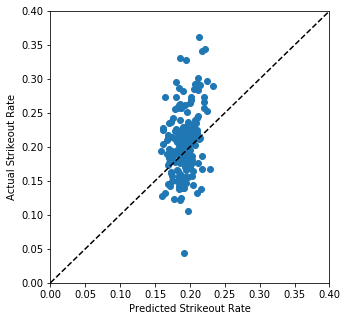

In [38]:
fig = plt.figure(figsize=(5,5))
plt.scatter(y_pred, y_test)
plt.plot([0., 0.4], [0., 0.4], 'k--')
plt.xlim([0, 0.4])
plt.ylim([0, 0.4])
plt.xlabel('Predicted Strikeout Rate')
plt.ylabel('Actual Strikeout Rate')
plt.show()

#### Optimized AdaBoost

In [39]:
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200, 300, 1000],
    'learning_rate': [0.1, 0.5, 1.0, 5.0, 10.0],
    'loss': ['linear', 'square', 'exponential']
}
# Create a based model
ab = AdaBoostRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = ab, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)

n = len(y_pred)
p = X_test.shape[1]

r2 = r2_score(y_test, y_pred)
adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)

print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")
print(f"Adjusted R^2: {adj_r2}")

Fitting 3 folds for each of 105 candidates, totalling 315 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   18.7s


{'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 20}
Mean Absolute Error: 0.036878172022345605
Adjusted R^2: -0.03884217364188047


[Parallel(n_jobs=-1)]: Done 315 out of 315 | elapsed:   22.9s finished


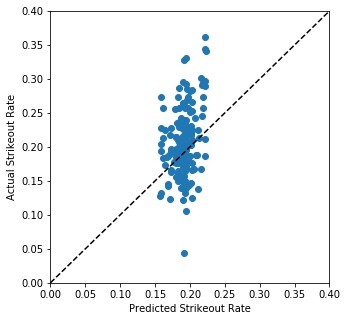

In [40]:
fig = plt.figure(figsize=(5,5))
plt.scatter(y_pred, y_test)
plt.plot([0., 0.4], [0., 0.4], 'k--')
plt.xlim([0, 0.4])
plt.ylim([0, 0.4])
plt.xlabel('Predicted Strikeout Rate')
plt.ylabel('Actual Strikeout Rate')
plt.show()

#### Optimized XGBoost

In [41]:
param_grid = {"max_depth": (2, 5, 20),
              "learning_rate": (0.01, 0.1, 0.4),
              "min_child_weight": (1, 3, 5)}
# Create a based model
xgb = XGBRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)

n = len(y_pred)
p = X_test.shape[1]

r2 = r2_score(y_test, y_pred)
adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)

print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")
print(f"Adjusted R^2: {adj_r2}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  66 out of  81 | elapsed:    1.3s remaining:    0.3s


{'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 1}
Mean Absolute Error: 0.03615223994445505
Adjusted R^2: -0.003171814076373458


[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    1.6s finished


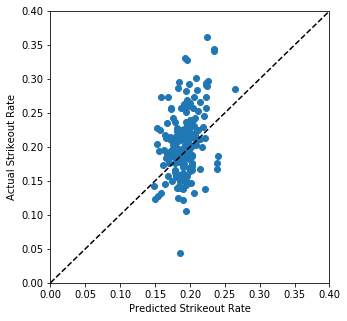

In [42]:
fig = plt.figure(figsize=(5,5))
plt.scatter(y_pred, y_test)
plt.plot([0., 0.4], [0., 0.4], 'k--')
plt.xlim([0, 0.4])
plt.ylim([0, 0.4])
plt.xlabel('Predicted Strikeout Rate')
plt.ylabel('Actual Strikeout Rate')
plt.show()